# Working with geospatial data in Python  

DataPhilly Workshop
Simon Kassel  
Data Scientist @ [Azavea](https://www.azavea.com/)  

January 21, 2021

### Agenda

1) The basics
 - Vector data
     - [GeoPandas](https://geopandas.org/)
     - [Shapely](https://towardsdatascience.com/geospatial-adventures-step-1-shapely-e911e4f86361)
 - Raster data (imagery)
     - [GDAL](https://gdal.org/)
     - [Rasterio](https://rasterio.readthedocs.io/en/latest/)
 - I/O
 - Windowed reading and writing  

2) Building training data for Machine Learning  
 - Creating chips (smaller images)
 - Rasterizing building labels

### Data
- *__scene.tif__*: an aerial image of a portion of Kampala, Uganda
- *__buildings.geojson__*: building polygons from the same location

### Video link: https://www.youtube.com/watch?v=KFO9zCFBwtY
### Must read: 
1. A scikit-learn compatible neural network library that wraps PyTorch --> https://skorch.readthedocs.io/en/stable/
2. Raster Vision --> https://www.azavea.com/blog/2023/01/05/introducing-raster-vision-v0-20/

In [4]:
import os
import sys
import glob

from shutil import rmtree

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import fiona
from pprint import pprint
from rasterio.features import Window
from rasterio.windows import bounds
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon, box
from PIL import Image
from rasterio.features import Window
from subprocess import call
from IPython import display

In [2]:
in_rst_folder = '../data/rst/2019_out_int_utm'
in_rst_file_list = glob.glob(os.path.join(in_rst_folder, '*.tif'))

in_vec = "../data/vec/mangrove_mekong_single_parts.geojson"

In [ ]:
for in_rst in in_rst_file_list:
    all_bldgs = gpd.read_file(in_vec)

    ################################################################
    with rasterio.open(in_rst) as src:
        img_bounds = src.bounds

    # left, bottom, right, top
    l, b, r, t = img_bounds
    img_bbox = Polygon([(l, b), (l, t), (r, t), (r, b)])
    bbox_gdf = gpd.GeoDataFrame({'geometry': [img_bbox]}, crs = 32648)
    #################################################################

    bldgs = gpd.overlay(all_bldgs, bbox_gdf, how='intersection')

    #################################################################

    rst_att = os.path.basename(in_rst).split('_')[0]
    out_folder = f"../data/rst_dl_512/{rst_att}"
    if not os.path.isdir(out_folder):
#         rmtree(out_folder)
        os.makedirs(f'{out_folder}/true')
        os.makedirs(f'{out_folder}/false')
        os.makedirs(f'{out_folder}/mask')
        os.makedirs(f'{out_folder}/mask_vec')


    mp = MultiPolygon(bldgs['geometry'].values)

    # specify the png image size (in pixels) 
    png_size = 512

    with rasterio.open(in_rst) as src:
        # gather width and height of input image
        width = src.width
        height = src.height
        data = src.read(1)

        # iterate over the image in a grid of 1200x1200 pixel squares
        for w in range(0, width, png_size):
            for h in range(0, height, png_size):
              # Read the input raster's data and metadata
              window = (w, h, w + png_size, h + png_size)

              # construct Window object using row/col and size
              win = Window(w, h, png_size, png_size)

              # find the corresponding spatial coordinates
              trans = src.window_transform(win)

              # read the window portion in as a numpy array
              a = src.read(window=win)

              # create shapely object that represents the bounds of the window
              p = src.profile.copy()
              p['width'] = win.width
              p['height'] = win.height
              p['transform'] = src.window_transform(win)
              with rasterio.open('/tmp/tmp.tif', 'w', **p) as dst:
                  bnds = dst.bounds

              x = Polygon(box(*bnds))

              # check whether the window intersects with any buildings
              has_bldg = x.intersects(mp)

              if has_bldg is True:
                  label = 'true'
                  label_1 = 'mask'

                  win_bldgs = gpd.clip(bldgs, x)

                  # save the image off as a png
                  fp_geojson = f'{out_folder}/{label_1}_vec/{w}-{h}.geojson'
                  fp_png = f'{out_folder}/{label_1}/{w}-{h}.tif'

                  win_bldgs.to_file(fp_geojson, driver='GeoJSON')

                  # Open example raster
                  with fiona.open(fp_geojson, "r") as shapefile:
                      shapes = [feature["geometry"] for feature in shapefile]

                  # Rasterize vector using the shape and coordinate system of the raster
                  rasterized = rasterio.features.rasterize(shapes,
                                                  out_shape = [png_size, png_size],
                                                  fill = 0,
                                                  out = None,
                                                  transform = src.window_transform(win),
                                                  all_touched = False,
                                                  default_value = 1,
                                                  dtype = None)

                  with rasterio.open(fp_png, "w",
                          driver = "GTiff",
                          transform = src.window_transform(win),
                          dtype = rasterio.uint8,
                          count = 1,
                          width = png_size,
                          height = png_size,
                          crs=CRS.from_epsg(32648)) as dst:
                      dst.write(rasterized, indexes = 1)

                  fp = f'{out_folder}/{label}/{w}-{h}.tif'
                  # Create the output profile
                  out_meta = src.meta.copy()
                  out_meta.update({"driver": "GTiff",
                                   "height": png_size,
                                   "width": png_size,
                                   "transform": src.window_transform(win)
                                   })

                  # Write the clipped raster to the output file
                  with rasterio.open(fp, "w", **out_meta) as dest_1:
                    dest_1.write(a)

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

In [ ]:
in_folder = '/home/duy/local/study/deep_learning/DL_2023/data/rst_dl_512'
out_folder = '/home/duy/local/study/deep_learning/DL_2023/data/rst_final_512_v1'

in_file_list = glob.glob(os.path.join(in_folder, '*/true/*.tif'))
print (len(in_file_list))

widths = []
heights = []

for in_rst in in_file_list:
    [width, height] = os.path.basename(in_file_list[0])[:-4].split('-')
    widths.append(int(width))
    heights.append(int(height))
    
# width, height = np.array(widths).max(), np.array(heights).max()

png_size = 1000
bands = ['aerosols', 'blue', 'green', 'red', 'rege1', 'rege2', 'rege3', 'nir', 'swir1', 'swir2']

for fn in set(in_file_list):
    fn = os.path.basename(fn)
#     print (fn)
    fns = []
    for band in bands:
#             print (band, glob.glob(os.path.join(in_folder, f'{band}/true/*{fn}*')))
        fns.append(glob.glob(os.path.join(in_folder, f'{band}/true/*{fn}*'))[0])

#     print (fns)
    if len(fns) == 10:
        in_files = " ".join(fns)
        print (in_files)
        out_file = in_files[:-4] + '.vrt'
        cmd = f'gdalbuildvrt -separate ./{out_file} {in_files}'
        os.system(cmd)
        cmd = f'gdal_translate ./{out_file} {out_folder}/tra_scene/{fn}'
#         os.system(cmd)
#         cmd = 'rm -rf ./temp.vrt'
#         os.system(cmd)

1130
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.9/site.py", line 606, in <module>
    main()
  File "/usr/lib/python3.9/site.py", line 589, in main
    known_paths = venv(known_paths)
  File "/usr/lib/python3.9/site.py", line 521, in venv
    addsitepackages(known_paths, [sys.prefix])
  File "/usr/lib/python3.9/site.py", line 376, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.9/site.py", line 214, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.9/site.py", line 164, in addpackage
    fullname = os.path.join(sitedir, name)
  File "/usr/lib/python3.9/posixpath.py", line 76, in join
    a = os.fspath(a)
KeyboardInterrupt


0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

ERROR 4: ./temp.vrt: No such file or directory


/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/stud

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.9/site.py", line 606, in <module>
    main()
  File "/usr/lib/python3.9/site.py", line 589, in main
    known_paths = venv(known_paths)
  File "/usr/lib/python3.9/site.py", line 521, in venv
    addsitepackages(known_paths, [sys.prefix])
  File "/usr/lib/python3.9/site.py", line 376, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.9/site.py", line 214, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.9/site.py", line 175, in addpackage
    exec(line)
  File "<string>", line 1, in <module>
KeyboardInterrupt


0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30./ho

ERROR 4: ./temp.vrt: No such file or directory


0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10

Traceback (most recent call last):
  File "/home/duy/.venvs/gee/bin/gdal_translate", line 3, in <module>
    import re
KeyboardInterrupt
Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.9/site.py", line 606, in <module>
    main()
  File "/usr/lib/python3.9/site.py", line 589, in main
    known_paths = venv(known_paths)
  File "/usr/lib/python3.9/site.py", line 521, in venv
    addsitepackages(known_paths, [sys.prefix])
  File "/usr/lib/python3.9/site.py", line 376, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.9/site.py", line 214, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.9/site.py", line 175, in addpackage
    exec(line)
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.9/importlib/util.py", line 2, in <module>
    from . import abc
  File "/usr/lib/python3.9/importlib/abc.py", lin

...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif


ERROR 4: ./temp.vrt: No such file or directory
Traceback (most recent call last):
  File "/home/duy/.venvs/gee/bin/gdalbuildvrt", line 5, in <module>
    from osgeo.bin import program
  File "/home/duy/.venvs/gee/lib/python3.9/site-packages/osgeo/__init__.py", line 14, in <module>
    _libs = { 
  File "/home/duy/.venvs/gee/lib/python3.9/site-packages/osgeo/__init__.py", line 15, in <dictcomp>
    re.split(r"-|\.", name)[0]: os.path.join(_libsdir, name) 
  File "/usr/lib/python3.9/re.py", line 231, in split
    return _compile(pattern, flags).split(string, maxsplit)
  File "/usr/lib/python3.9/re.py", line 304, in _compile
    p = sre_compile.compile(pattern, flags)
  File "/usr/lib/python3.9/sre_compile.py", line 768, in compile
    code = _code(p, flags)
  File "/usr/lib/python3.9/sre_compile.py", line 604, in _code
    _compile_info(code, p, flags)
  File "/usr/lib/python3.9/sre_compile.py", line 590, in _compile_info
    charset, hascased = _optimize_charset(charset)
  File "/usr/li

/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /hom

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.9/site.py", line 606, in <module>
    main()
  File "/usr/lib/python3.9/site.py", line 589, in main
    known_paths = venv(known_paths)
  File "/usr/lib/python3.9/site.py", line 521, in venv
    addsitepackages(known_paths, [sys.prefix])
  File "/usr/lib/python3.9/site.py", line 376, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.9/site.py", line 214, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.9/site.py", line 175, in addpackage
    exec(line)
KeyboardInterrupt


...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50

Input file size is 1000, 1000
0...10...20...30./home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.9/site.py", line 606, in <module>
    main()
  File "/usr/lib/python3.9/site.py", line 589, in main
    known_paths = venv(known_paths)
  File "/usr/lib/python3.9/site.py", line 521, in venv
    addsitepackages(known_paths, [sys.prefix])
  File "/usr/lib/python3.9/site.py", line 376, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.9/site.py", line 214, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.9/site.py", line 175, in addpackage
    exec(line)
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.9/importlib/util.py", line 2, in <module>
    from . import abc
  File "/usr/lib/python3.9/importlib/abc.py", line 17, in <module>
    from typing import Protocol, runtime_checkable
  File "/usr/lib/python3.9/typing.py", line 21, in <module>
    impo

...20...30...40...50...60...70...80...90/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif


ERROR 4: ./temp.vrt: No such file or directory


0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

ERROR 4: ./temp.vrt: No such file or directory


0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0/home/duy/local/stu

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.9/site.py", line 79, in <module>
    import os
  File "/usr/lib/python3.9/os.py", line 29, in <module>
    from _collections_abc import _check_methods
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 851, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 647, in _compile_bytecode
KeyboardInterrupt


0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.9/site.py", line 606, in <module>
    main()
  File "/usr/lib/python3.9/site.py", line 589, in main
    known_paths = venv(known_paths)
  File "/usr/lib/python3.9/site.py", line 521, in venv
    addsitepackages(known_paths, [sys.prefix])
  File "/usr/lib/python3.9/site.py", line 376, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.9/site.py", line 214, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.9/site.py", line 166, in addpackage
    f = io.TextIOWrapper(io.open_code(fullname))
KeyboardInterrupt


/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30./home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.9/site.py", line 606, in <module>
    main()
  File "/usr/lib/python3.9/site.py", line 589, in main
    known_paths = venv(known_paths)
  File "/usr/lib/python3.9/site.py", line 521, in venv
    addsitepackages(known_paths, [sys.prefix])
  File "/usr/lib/python3.9/site.py", line 376, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.9/site.py", line 214, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.9/site.py", line 175, in addpackage
    exec(line)
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.9/importlib/util.py", line 2, in <module>
    from . import abc
  File "/usr/lib/python3.9/importlib/abc.py", line 17, in <module>
    from typing import Protocol, runtime_checkable
  File "/usr/lib/python3.9/typing.py", line 21, in <module>
    impo

/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/dee

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...4

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/duy/local/study/deep_learning/DL_2023/data/rst_dl/aerosols/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/blue/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/green/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/red/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege2/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/rege3/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/nir/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir1/true/19000-16000.tif /home/duy/local/study/deep_learning/DL_2023/data/rst_dl/swir2/true/19000-16000.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1

In [14]:
# !head -n 5 ../data/vec/mangrove_mekong_single_parts.geojson

We can work with vector data in python using [GeoPandas](https://geopandas.org/) geodataframes

In [3]:
in_vec = "../data/vec/mangrove_mekong_single_parts.geojson"
in_rst = "../data/rst/2019_out_int_utm/nir_2019.tif"

g = gpd.read_file(in_vec)

# g.head()
# g[g['Classvalue'] == 1]

<AxesSubplot:>

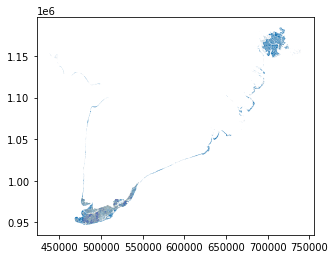

In [4]:
g.plot()

Windowed reading and writing: grab a 1k x 1k pixel image from the very center of this one

In [5]:
with rasterio.open(in_rst) as src:
    witdth = src.width
    hight = src.height
    p = src.profile.copy()

col_off = (src.width / 2) - (1000 / 2)
row_off = (src.height / 2) - (1000 / 2)

pprint(p['transform'])

win = Window(col_off=col_off, row_off=row_off, width=1000, height=1000)
x = rasterio.open(in_rst).window_transform(win)
print (x)

with rasterio.open(in_rst) as src:
    f = src.read(window=win)
    p = src.profile.copy()
    p['width'] = win.width
    p['height'] = win.height
    p['transform'] = src.window_transform(win)

print (f.shape)

Affine(10.0, 0.0, 434457.45416107646,
       0.0, -10.0, 1194287.3112105692)
| 10.00, 0.00, 584967.45|
| 0.00,-10.00, 1073712.31|
| 0.00, 0.00, 1.00|
(1, 1000, 1000)


In [ ]:
# with rasterio.open('sample.tif', 'w', **p) as dst:
#     dst.write(f)

In [ ]:
# !ls

## 2) Building training data for Machine Learning  

Prep data for building chip classification

BoundingBox(left=434457.45416107646, bottom=943137.3112105692, right=745477.4541610765, top=1194287.3112105692)


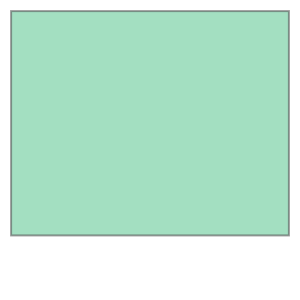

In [6]:
all_bldgs = gpd.read_file(in_vec)

with rasterio.open(in_rst) as src:
    img_bounds = src.bounds

print (img_bounds)

# left, bottom, right, top
l, b, r, t = img_bounds

img_bbox = Polygon([(l, b), (l, t), (r, t), (r, b)])
img_bbox

<AxesSubplot:>

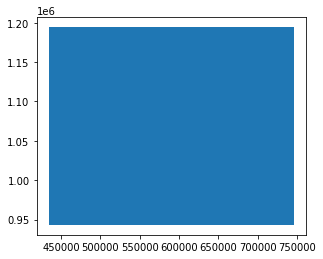

In [7]:
bbox_gdf = gpd.GeoDataFrame({'geometry': [img_bbox]}, crs = 32648)
bbox_gdf.plot()

In [ ]:
# all_bldgs

<AxesSubplot:>

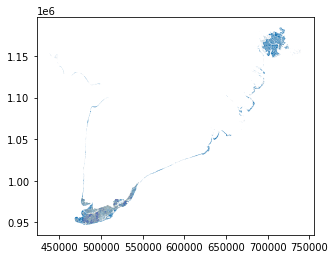

In [8]:
bldgs = gpd.overlay(all_bldgs, bbox_gdf, how='intersection')
bldgs.plot()

In [11]:
import os
from shutil import rmtree

rst_att = "nir_2019"
out_folder = f"../data/rst/raster/{rst_att}"
if os.path.isdir(out_folder):
    rmtree(out_folder)
os.makedirs(f'{out_folder}/true')
os.makedirs(f'{out_folder}/false')
os.makedirs(f'{out_folder}/mask')
os.makedirs(f'{out_folder}/mask_vec')


mp = MultiPolygon(bldgs['geometry'].values)

# specify the png image size (in pixels) 
png_size = 1000

In [12]:
with rasterio.open(in_rst) as src:
    # gather width and height of input image
    width = src.width
    height = src.height
    data = src.read(1)

    # iterate over the image in a grid of 1200x1200 pixel squares
    for w in range(0, width, png_size):
        for h in range(0, height, png_size):
          # Read the input raster's data and metadata
          window = (w, h, w + png_size, h + png_size)

          # construct Window object using row/col and size
          win = Window(w, h, png_size, png_size)

          # find the corresponding spatial coordinates
          trans = src.window_transform(win)
          
          # read the window portion in as a numpy array
          a = src.read(window=win)
          
          # create shapely object that represents the bounds of the window
          p = src.profile.copy()
          p['width'] = win.width
          p['height'] = win.height
          p['transform'] = src.window_transform(win)
          with rasterio.open('/tmp/tmp.tif', 'w', **p) as dst:
              bnds = dst.bounds
          
          x = Polygon(box(*bnds))
          
          # check whether the window intersects with any buildings
          has_bldg = x.intersects(mp)
          
          if has_bldg is True:
              label = 'true'
              label_1 = 'mask'

              win_bldgs = gpd.clip(bldgs, x)

              # save the image off as a png
              fp_geojson = f'{out_folder}/{label_1}_vec/{w}-{h}.geojson'
              fp_png = f'{out_folder}/{label_1}/{w}-{h}.png'

              win_bldgs.to_file(fp_geojson, driver='GeoJSON')

              # Open example raster
              with fiona.open(fp_geojson, "r") as shapefile:
                  shapes = [feature["geometry"] for feature in shapefile]

              # Rasterize vector using the shape and coordinate system of the raster
              rasterized = rasterio.features.rasterize(shapes,
                                              out_shape = [png_size, png_size],
                                              fill = 0,
                                              out = None,
                                              transform = src.window_transform(win),
                                              all_touched = False,
                                              default_value = 1,
                                              dtype = None)

              with rasterio.open(fp_png, "w",
                      driver = "GTiff",
                      transform = src.window_transform(win),
                      dtype = rasterio.uint8,
                      count = 1,
                      width = png_size,
                      height = png_size,
                      crs=CRS.from_epsg(32648)) as dst:
                  dst.write(rasterized, indexes = 1)

              fp = f'{out_folder}/{label}/{w}-{h}.png'
              # Create the output profile
              out_meta = src.meta.copy()
              out_meta.update({"driver": "GTiff",
                               "height": png_size,
                               "width": png_size,
                               "transform": src.window_transform(win)
                               })

              # Write the clipped raster to the output file
              with rasterio.open(fp, "w", **out_meta) as dest_1:
                dest_1.write(a)

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/duy/.venvs/gee

In [ ]:
# display.Image(filename=f'{out_folder}/false/{os.listdir(f"{out_folder}/false")[0]}')

In [13]:
# display.Image(filename=f'{out_folder}/true/{os.listdir(f"{out_folder}/true")[1]}')

In [6]:
import os
import glob

in_folder = '/home/duy/local/study/deep_learning/DL_2023/data/rst_final_512_v1'
in_file_list = glob.glob(os.path.join(in_folder, 'tra_truth_all/*.tif'))
len(in_file_list)

113

In [11]:
from osgeo import gdal
import numpy as np

for in_rst in in_file_list:
#     print (in_rst)
    # Open the image using gdal
    img = gdal.Open(in_rst)
    
    srcband = img.GetRasterBand(1)
    inputArray = np.array(img.GetRasterBand(1).ReadAsArray())

    # Print the maximum DN value
    if inputArray.max() != 1:
        print(inputArray.max())